# Project: Microsoft Stock Price Prediction with Machine Learning

**Objective:** Build a time-series forecasting model using TensorFlow to predict
Microsoft’s stock price based on historical data.

# Dataset: Microsoft Stock Price Dataset

# Importing Necessary Libraries and Dataset:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the dataset using Pandas and explore its structure.

In [ ]:
import pandas as pd

df = pd.read_csv('/content/MicrosoftStock.csv')
print(df.head())


    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT


# Data Insights

In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB
None
               index         open         high          low        close  \
count    1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean   390827.000000    51.026394    51.436007    50.630397    51.063081   
std       363.586303    14.859387    14.930144    14.774630    14.852117   
min    390198.000000    27.350000    27.600000    27.230000    27.370000   
25%    390512.500000    40.305000    40.637500    39.870000    40.310000   


# Data Preprocessing:

Convert the date column into DateTime format and set it as an index.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
display(df.head())

,index,open,high,low,close,volume,Name
date,,,,,,,
2013-02-08,390198,27.35,27.71,27.31,27.55,33318306,MSFT
2013-02-11,390199,27.65,27.92,27.50,27.86,32247549,MSFT
2013-02-12,390200,27.88,28.00,27.75,27.88,35990829,MSFT
2013-02-13,390201,27.93,28.11,27.88,28.03,41715530,MSFT
2013-02-14,390202,27.92,28.06,27.87,28.04,32663174,MSFT


Handle missing values by filling them using interpolation.

In [ ]:
df.interpolate(method='linear', inplace=True)
print(df.isnull().sum())

index     0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


/tmp/ipython-input-7-2336848238.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [ ]:
df.drop('Name', axis=1, inplace=True)
display(df.head())

,index,open,high,low,close,volume
date,,,,,,
2013-02-08,390198,27.35,27.71,27.31,27.55,33318306
2013-02-11,390199,27.65,27.92,27.50,27.86,32247549
2013-02-12,390200,27.88,28.00,27.75,27.88,35990829
2013-02-13,390201,27.93,28.11,27.88,28.03,41715530
2013-02-14,390202,27.92,28.06,27.87,28.04,32663174


Normalize numerical features using MinMaxScaler to improve model
performance.

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
display(df.head())

,index,open,high,low,close,volume
date,,,,,,
2013-02-08,0.000000,0.000000,0.001607,0.001203,0.002661,0.107470
2013-02-11,0.000795,0.004425,0.004674,0.004061,0.007244,0.103026
2013-02-12,0.001590,0.007818,0.005842,0.007821,0.007540,0.118563
2013-02-13,0.002385,0.008556,0.007449,0.009776,0.009758,0.142324
2013-02-14,0.003180,0.008408,0.006718,0.009626,0.009905,0.104751


Create additional features like:

o Moving Averages (SMA, EMA)

o Bollinger Bands

o RSI (Relative Strength Index)

In [ ]:
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

df['BB_upper'] = df['close'].rolling(window=20).mean() + 2 * df['close'].rolling(window=20).std()
df['BB_lower'] = df['close'].rolling(window=20).mean() - 2 * df['close'].rolling(window=20).std()

delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

df.dropna(inplace=True)

display(df.head())

,index,open,high,low,close,volume,SMA_50,EMA_50,BB_upper,BB_lower,RSI
date,,,,,,,,,,,
2013-04-22,0.038951,0.043517,0.052286,0.045721,0.051153,0.541553,0.014345,0.016771,0.043267,0.002904,66.188198
2013-04-23,0.039746,0.049417,0.048196,0.047376,0.047753,0.214178,0.015247,0.017986,0.047122,0.002656,66.293930
2013-04-24,0.040541,0.048237,0.063093,0.050684,0.064902,0.346457,0.016400,0.019826,0.055200,-0.000092,71.428571
2013-04-25,0.041335,0.064316,0.076530,0.064822,0.067564,0.428592,0.017601,0.021698,0.062406,-0.002020,71.715818
2013-04-26,0.042130,0.067119,0.063970,0.063468,0.065346,0.167575,0.018712,0.023410,0.067825,-0.002730,71.333333


Split dataset into training (80%) and testing (20%) sets.

In [ ]:
training_size = int(len(df) * 0.80)
test_size = len(df) - training_size
train_data, test_data = df.iloc[0:training_size,:], df.iloc[training_size:len(df),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 4])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

# Exploratory Data Analysis (EDA):

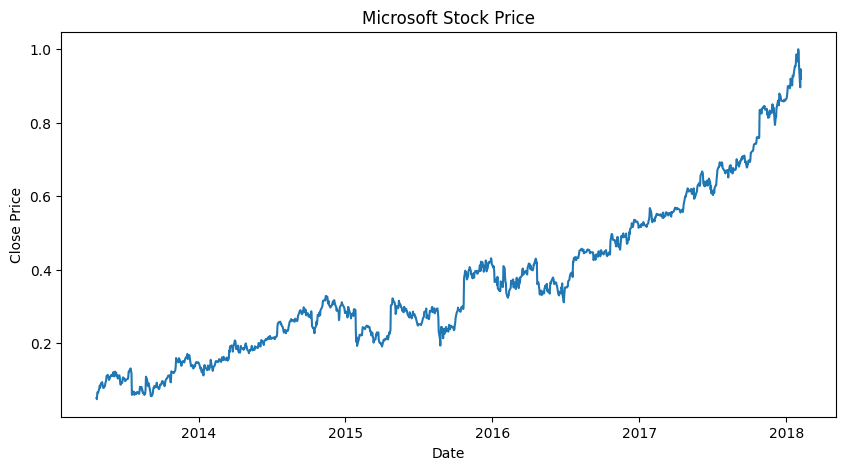

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['close'])
plt.title('Microsoft Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

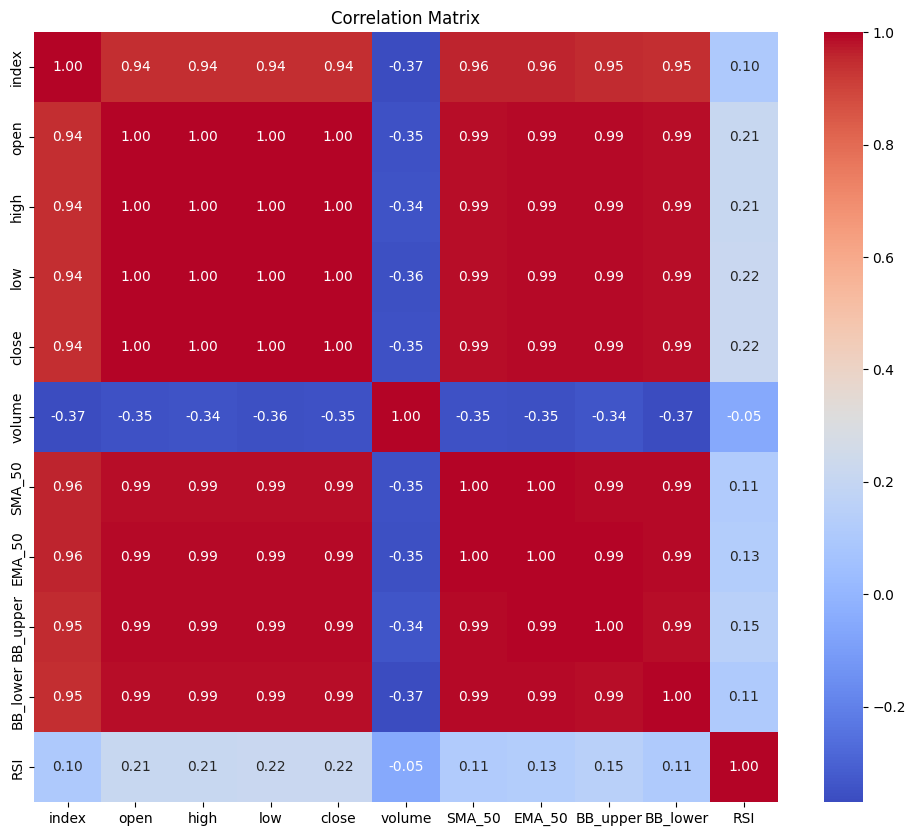

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

<Figure size 640x480 with 0 Axes>

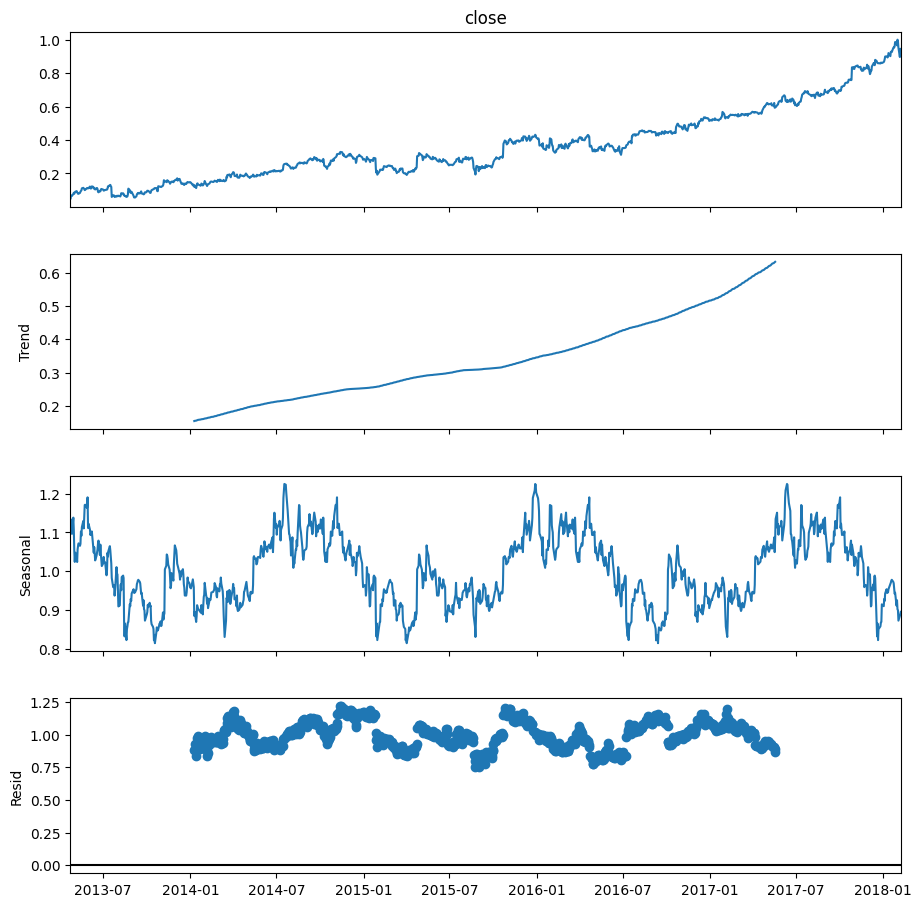

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['close'], model='multiplicative', period=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10, 10)

# Model Training and Selection:

Train different machine learning models:

o Linear Regression

o Random Forest

o XGBoost


Linear Regression RMSE: 0.038672356414183935
Random Forest RMSE: 0.2517710634008997
XGBoost RMSE: 0.25977069316630746


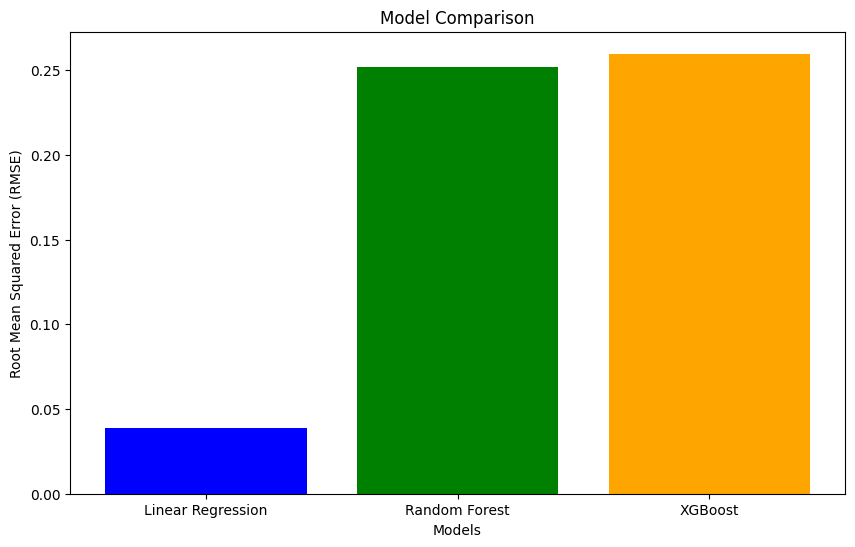

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Reshape the data for the models
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# --- Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train_reshaped, y_train)
y_pred_lr = lr_model.predict(X_test_reshaped)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f'Linear Regression RMSE: {rmse_lr}')

# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_reshaped, y_train)
y_pred_rf = rf_model.predict(X_test_reshaped)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest RMSE: {rmse_rf}')

# --- XGBoost ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train_reshaped, y_train)
y_pred_xgb = xgb_model.predict(X_test_reshaped)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'XGBoost RMSE: {rmse_xgb}')

# --- Comparison Plot ---
models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmse_scores = [rmse_lr, rmse_rf, rmse_xgb]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_scores, color=['blue', 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Model Comparison')
plt.show()

FOR LSTM ARCHITECTURE

In [ ]:
df.reset_index(inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.sort_index()
display(df.head())

,index,open,high,low,close,volume,SMA_50,EMA_50,BB_upper,BB_lower,RSI
date,,,,,,,,,,,
2013-04-22,0.038951,0.043517,0.052286,0.045721,0.051153,0.541553,0.014345,0.016771,0.043267,0.002904,66.188198
2013-04-23,0.039746,0.049417,0.048196,0.047376,0.047753,0.214178,0.015247,0.017986,0.047122,0.002656,66.293930
2013-04-24,0.040541,0.048237,0.063093,0.050684,0.064902,0.346457,0.016400,0.019826,0.055200,-0.000092,71.428571
2013-04-25,0.041335,0.064316,0.076530,0.064822,0.067564,0.428592,0.017601,0.021698,0.062406,-0.002020,71.715818
2013-04-26,0.042130,0.067119,0.063970,0.063468,0.065346,0.167575,0.018712,0.023410,0.067825,-0.002730,71.333333


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Multivariate features
features = ['close', 'volume', 'RSI', 'SMA_50', 'EMA_50', 'BB_upper', 'BB_lower']
target = 'close'

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[features])
target_scaled = scaler.fit_transform(df[[target]])

# Train-test split for ML models
X_ml = data_scaled[:-1]
y_ml = target_scaled[1:].ravel()
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, shuffle=False, test_size=0.2)

# ML Models
lr = LinearRegression().fit(X_train_ml, y_train_ml)
rf = RandomForestRegressor().fit(X_train_ml, y_train_ml)
xgb_model = xgb.XGBRegressor(verbosity=0).fit(X_train_ml, y_train_ml)

y_pred_lr = lr.predict(X_test_ml)
y_pred_rf = rf.predict(X_test_ml)
y_pred_xgb = xgb_model.predict(X_test_ml)

# Use LSTM (Deep Learning Model) for accurate time series forecasting.

In [ ]:
import numpy as np

# Create LSTM sequences
def create_seq_data(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step, 0])  # Predict 'Close'
    return np.array(X), np.array(y)

time_step = 60
X_lstm, y_lstm = create_seq_data(data_scaled, time_step)

X_train_lstm, X_test_lstm = X_lstm[:int(len(X_lstm)*0.8)], X_lstm[int(len(X_lstm)*0.8):]
y_train_lstm, y_test_lstm = y_lstm[:int(len(X_lstm)*0.8)], y_lstm[int(len(X_lstm)*0.8):]

In [ ]:
from tensorflow.keras.layers import Bidirectional, Dropout

# Advanced LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_lstm, epochs=150, batch_size=64, verbose=1)

y_pred_lstm = model.predict(X_test_lstm).reshape(-1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - loss: 0.0371
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - loss: 0.0041
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step - loss: 0.0017
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - loss: 0.0014
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - loss: 0.0012
Epoch 6/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - loss: 9.7775e-04
Epoch 7/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - loss: 9.9732e-04
Epoch 8/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 603ms/step - loss: 9.3201e-04
Epoch 9/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 672ms/step - loss: 7.9727e-04
Epoch 10/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step - loss: 7.1686e-04
Epoch 11/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step - loss: 6.8329e-04
Epoch 12/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - loss: 7.0160e-04
Epoch 13/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 444ms/step - loss: 6.9102e-04
Epoch 14/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - loss: 6.5700e-04


Improvement

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 426ms/step - accuracy: 0.0000e+00 - loss: 0.0351 - val_accuracy: 0.0043 - val_loss: 0.0039
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step - accuracy: 0.0000e+00 - loss: 0.0033 - val_accuracy: 0.0043 - val_loss: 0.0033
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.0000e+00 - loss: 0.0019 - val_accuracy: 0.0043 - val_loss: 0.0045
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 458ms/step - accuracy: 0.0000e+00 - loss: 0.0015 - val_accuracy: 0.0043 - val_loss: 0.0029
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step - accuracy: 0.0000e+00 - loss: 0.0012 - val_accuracy: 0.0043 - val_loss: 0.0018
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 470ms/step - accuracy: 0.0000e+00 - loss: 0.0010 - val_accuracy: 0.0043 - val_loss: 0.0036
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - accuracy: 0.0000e+00 - loss: 9.1548e-04 - val_accuracy: 0.0043 - val_loss: 0.0013
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accur

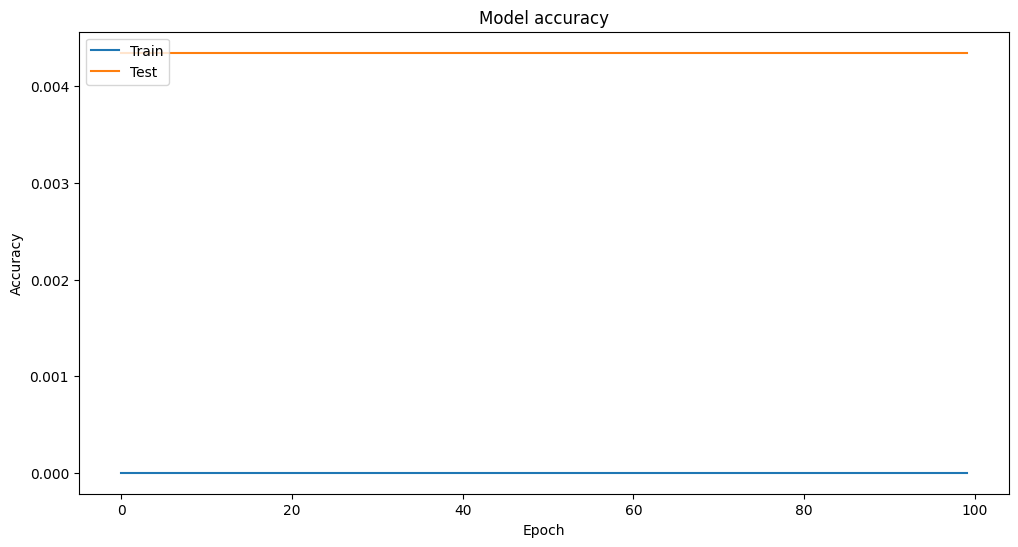

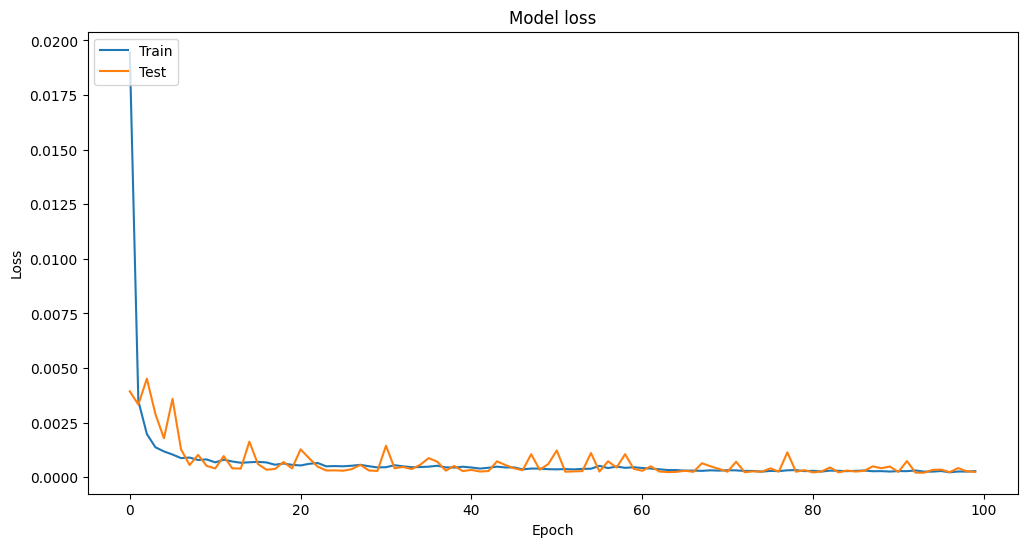

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step


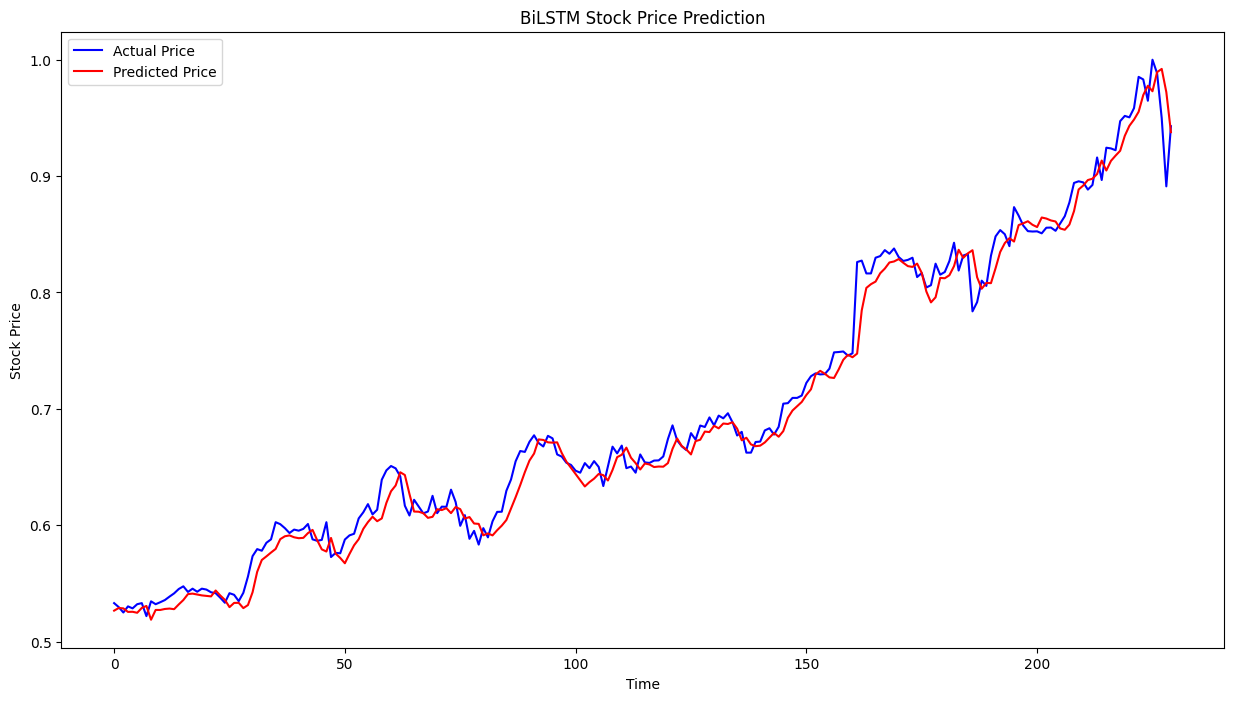

In [ ]:
from tensorflow.keras.layers import Bidirectional, Dropout, Dense, LSTM
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# Advanced BiLSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Make predictions
y_pred_bilstm = model.predict(X_test_lstm).reshape(-1)

# Plot actual vs. predicted
plt.figure(figsize=(15, 8))
plt.plot(y_test_lstm, color='blue', label='Actual Price')
plt.plot(y_pred_bilstm, color='red', label='Predicted Price')
plt.title('BiLSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluation function
def evaluate(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# Collect results
results = [
    evaluate(y_test_ml, y_pred_lr, "Linear Regression"),
    evaluate(y_test_ml, y_pred_rf, "Random Forest"),
    evaluate(y_test_ml, y_pred_xgb, "XGBoost"),
    evaluate(y_test_lstm, y_pred_lstm, "Advanced LSTM"),
]

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

               Model      RMSE       MAE        R2
0  Linear Regression  0.013165  0.008733  0.989213
1      Random Forest  0.207483  0.165129 -1.679136
2            XGBoost  0.208798  0.166223 -1.713207
3      Advanced LSTM  0.018961  0.014749  0.976528


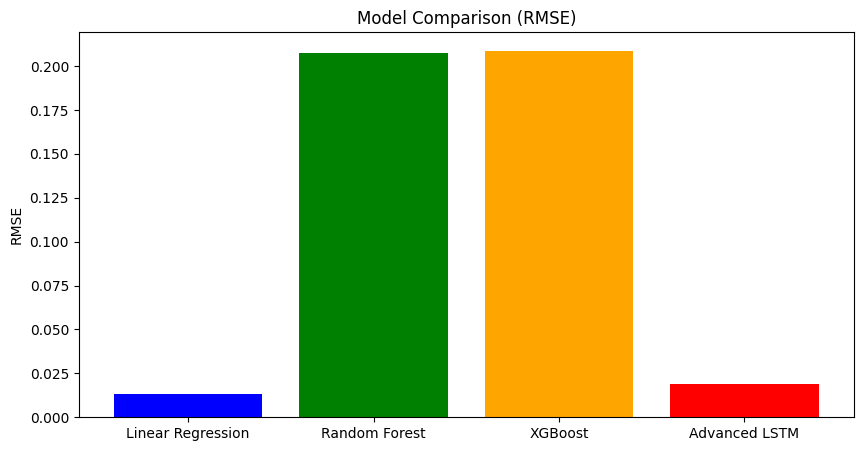

In [ ]:
#  Bar chart of RMSE
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["RMSE"], color=['blue', 'green', 'orange', 'red'])
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.show()

In [ ]:
df.tail()

,index,open,high,low,close,volume,SMA_50,EMA_50,BB_upper,BB_lower,RSI
date,,,,,,,,,,,
2018-02-01,0.996820,0.994837,1.000000,0.997914,0.988912,0.165204,0.881546,0.890886,1.009467,0.862413,73.303167
2018-02-02,0.997615,0.977873,0.969330,0.966612,0.952247,0.167859,0.884281,0.893293,1.008866,0.869919,57.665260
2018-02-05,0.998410,0.932438,0.958668,0.913972,0.896363,0.180991,0.885547,0.893413,1.009078,0.869426,48.955224
2018-02-06,0.999205,0.878301,0.932890,0.872612,0.945594,0.251415,0.887978,0.895459,1.008935,0.874078,53.253144
2018-02-07,1.000000,0.931406,0.937199,0.932020,0.920166,0.139801,0.889855,0.896428,1.007869,0.877199,48.773160
